# Collect Images of Solar Prediction Experiment and Make a Movie

Use this script to collect the images downloaded with the "NetworkCamera Download Solar Prediction.ipynb". Make a movie and a unified DataFrame.

In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymap3d
from PIL import Image
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import CameraNetwork
import CameraNetwork.global_settings as gs
import cv2
import glob
import Image
import ImageDraw
import time
from tqdm import tqdm_notebook
import traceback

/home/amitibo/code/cameranetwork/CameraNetwork/transformation_matrices.py:1934: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


## Create Unified DataFrame

In [2]:
BASE_PATH = "/VISL2_net/amitibo/experiment_forecast_2017_08/"
date = "2017_8_15"

In [3]:
dfs = {}
paths = sorted(glob.glob(os.path.join(BASE_PATH, "cam_*")))
for path in paths:
    df_path = os.path.join(path, date, "df.pkl")
    if not os.path.exists(df_path):
        continue
    cam_name = os.path.split(path)[1]
    dfs[cam_name] = pd.read_pickle(df_path)
    dfs[cam_name].index = pd.MultiIndex.from_tuples(dfs[cam_name].index)
    dfs[cam_name] = dfs[cam_name].reset_index().drop('level_1', axis=1).set_index("level_0")

In [4]:
joint_df = pd.concat(dfs, axis=1)
joint_df = joint_df.reindex_axis(sorted(joint_df.columns), axis=1)

In [5]:
joint_df.to_csv("/VISL2_net/amitibo/experiment_forecast_2017_08/df_2017_08_15.csv")

In [6]:
joint_df.head()

cam_110                                     cam_111  \
                    altitude latitude longitude path serial_num altitude   
level_0                                                                    
2017-08-15 00:00:00      NaN      NaN       NaN  NaN        NaN      NaN   
2017-08-15 00:30:00      NaN      NaN       NaN  NaN        NaN      NaN   
2017-08-15 01:00:00      NaN      NaN       NaN  NaN        NaN      NaN   
2017-08-15 01:30:00      NaN      NaN       NaN  NaN        NaN      NaN   
2017-08-15 02:00:00      NaN      NaN       NaN  NaN        NaN      NaN   

                                                           ...      cam_123  \
                    latitude longitude path serial_num     ...     altitude   
level_0                                                    ...                
2017-08-15 00:00:00      NaN       NaN  NaN        NaN     ...          NaN   
2017-08-15 00:30:00      NaN       NaN  NaN        NaN     ...          NaN   
2017-08-15 01:00:00      NaN       NaN  NaN        NaN     ...          NaN   
2017-08-15 01:30:00      NaN       NaN  NaN        NaN     ...          NaN   
2017-08-15 02:00:00      NaN       NaN  NaN        NaN     ...          NaN   

                                                        cam_219             \
                    latitude longitude path serial_num altitude   latitude   
level_0                                                                      
2017-08-15 00:00:00      NaN       NaN  NaN        NaN     17.0  32.789337   
2017-08-15 00:30:00      NaN       NaN  NaN        NaN     17.0  32.789337   
2017-08-15 01:00:00      NaN       NaN  NaN        NaN     17.0  32.789337   
2017-08-15 01:30:00      NaN       NaN  NaN        NaN     17.0  32.789337   
2017-08-15 02:00:00      NaN       NaN  NaN        NaN     17.0  32.789337   

                                \
                     longitude   
level_0                          
2017-08-15 00:00:00  35.040619   
2017-08-15 00:30:00  35.040619   
2017-08-15 01:00:00  35.040619   
2017-08-15 01:30:00  35.040619   
2017-08-15 02:00:00  35.040619   

                                                                        \
                                                                  path   
level_0                                                                  
2017-08-15 00:00:00  /VISL2_net/amitibo/experiment_forecast_2017_08...   
2017-08-15 00:30:00  /VISL2_net/amitibo/experiment_forecast_2017_08...   
2017-08-15 01:00:00  /VISL2_net/amitibo/experiment_forecast_2017_08...   
2017-08-15 01:30:00  /VISL2_net/amitibo/experiment_forecast_2017_08...   
2017-08-15 02:00:00  /VISL2_net/amitibo/experiment_forecast_2017_08...   

                                 
                     serial_num  
level_0                          
2017-08-15 00:00:00  4102824541  
2017-08-15 00:30:00  4102824541  
2017-08-15 01:00:00  4102824541  
2017-08-15 01:30:00  4102824541  
2017-08-15 02:00:00  4102824541  

[5 rows x 70 columns]

## Show Images

In [7]:
def convertMapData(lat, lon, hgt=0, lat0=32.775776, lon0=35.024963, alt0=229):
    """Convert lat/lon/height data to grid data."""

    n, e, d = pymap3d.geodetic2ned(
        lat, lon, hgt,
        lat0=lat0, lon0=lon0, h0=alt0)

    x, y, z = e, n, -d

    return x, y


## Scan the Data to Get Boundaries

In [136]:
IMG_SIZE = 1600
MARGIN = 1000
xs, ys = [], []
for _, row in joint_df.iterrows():
    for path, lat, lon in zip(paths, latitudes, longitudes):
        if pd.isnull(path):
            continue
        x, y = convertMapData(lat, lon)
        xs.append(x)
        ys.append(y)
        
xs = np.array(xs)
ys = np.array(ys)
offset = min(xs.min(), ys.min()) - 2*MARGIN
xs = xs - offset
ys = ys - offset
scale = (max(xs.max(), ys.max()) + 2*MARGIN) / IMG_SIZE

## Paste the Images

In [137]:
def paste_image(cam_index, black_img, img, lat, lon, offset, scale):
    x, y = convertMapData(lat, lon)
    x = int((x - offset) / scale)
    y = int((y - offset) / scale)
    w, h = img.size
    img = img.resize((2*w ,2*h), Image.ANTIALIAS)
    if cam_index == u"cam_219":
        #
        # Move and fix the ground image.
        #
        x += 200
        y -= 400
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
        
    coords = (x-w, y-h, x+w, y+h)
    black_img.paste(img, coords)
    return black_img

In [140]:
video = cv2.VideoWriter(
    'solar_forcast.avi',
    cv2.VideoWriter_fourcc('X','2','6','4'),
    6,
    (IMG_SIZE, IMG_SIZE)
)

for _, row in tqdm_notebook(joint_df.iterrows()):
    black_img = Image.fromarray(np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8))
    
    paths = row.loc[:, "path"]
    latitudes = row.loc[:, "latitude"]
    longitudes = row.loc[:, "longitude"]
    for cam_index in paths.index:
        if pd.isnull(paths[cam_index]):
            continue
        img = Image.open(paths[cam_index])
        paste_image(
            cam_index,
            black_img,
            img,
            latitudes[cam_index],
            longitudes[cam_index],
            offset,
            scale
        )
    
    black_img = black_img.transpose(Image.FLIP_TOP_BOTTOM)
    video.write(cv2.cvtColor(np.array(black_img), cv2.COLOR_RGB2BGR))

video.release()

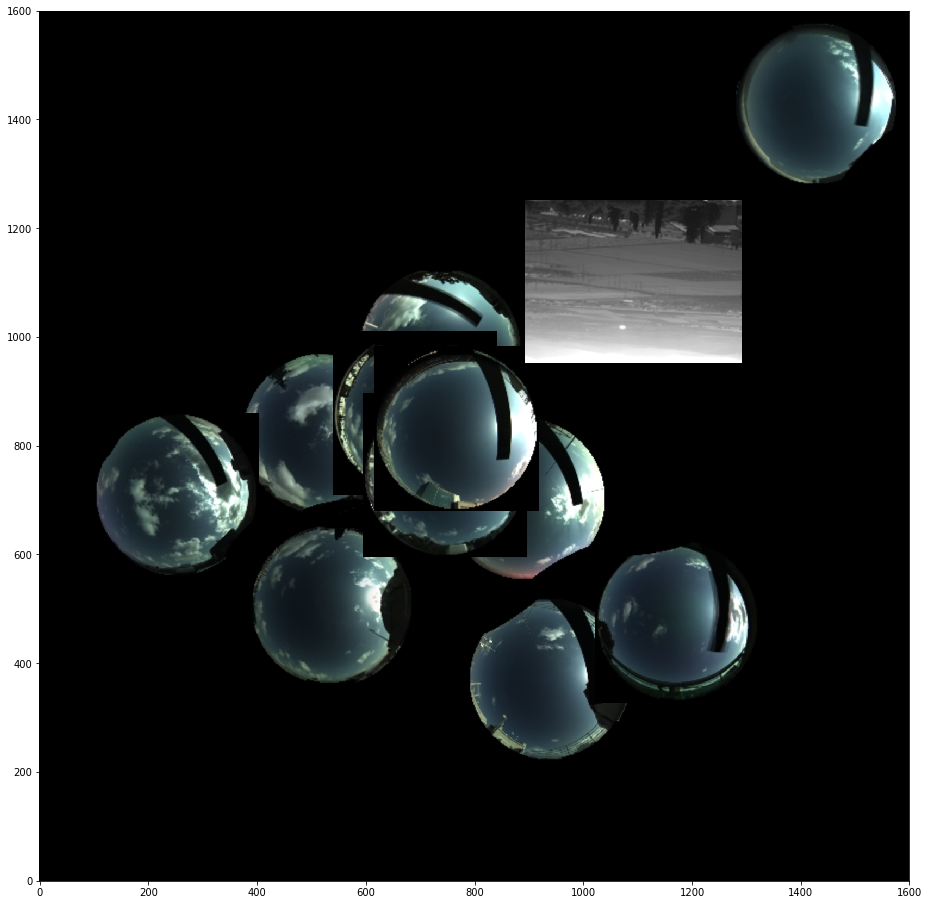

In [139]:
plt.figure(figsize=(16, 16))
plt.imshow(np.array(black_img), origin='bottom')

In [62]:
img = Image.open('/VISL2_net/amitibo/experiment_forecast_2017_08/cam_219/2017_8_15/1502755200.0_2017_08_15_00_00_00_0.jpg')

In [63]:
paste_image(black_img, img, 32.7893, 35.0406, offset, scale)

239 (710, 739, 910, 889)
239


<Image.Image image mode=RGB size=1600x1600 at 0x7F130104AFC8>

In [64]:
offset

-5997.3219056566595

239 (710, 739, 910, 889)
239


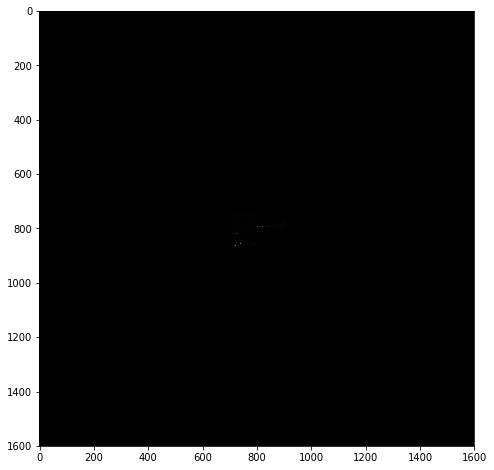

In [65]:
plt.imshow(np.array(paste_image(black_img, img, 32.7893, 35.0406, offset, scale)))

In [74]:
row = next(it)[1]

In [78]:
row.index

MultiIndex(levels=[[u'cam_110', u'cam_111', u'cam_112', u'cam_114', u'cam_115', u'cam_116', u'cam_117', u'cam_118', u'cam_119', u'cam_120', u'cam_121', u'cam_122', u'cam_123', u'cam_219'], [u'path', u'longitude', u'latitude', u'altitude', u'serial_num']],
           labels=[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13], [3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4]])

In [85]:
pd.notnull(row.loc[:, "path"][-1])

True

In [76]:
plt.subplots(ncols=4, nrows=4, figsize=(16, 16))
for k in row.iteritems():
    print k


(('cam_110', 'altitude'), nan)
(('cam_110', 'latitude'), nan)
(('cam_110', 'longitude'), nan)
(('cam_110', 'path'), nan)
(('cam_110', 'serial_num'), nan)
(('cam_111', 'altitude'), nan)
(('cam_111', 'latitude'), nan)
(('cam_111', 'longitude'), nan)
(('cam_111', 'path'), nan)
(('cam_111', 'serial_num'), nan)
(('cam_112', 'altitude'), nan)
(('cam_112', 'latitude'), nan)
(('cam_112', 'longitude'), nan)
(('cam_112', 'path'), nan)
(('cam_112', 'serial_num'), nan)
(('cam_114', 'altitude'), nan)
(('cam_114', 'latitude'), nan)
(('cam_114', 'longitude'), nan)
(('cam_114', 'path'), nan)
(('cam_114', 'serial_num'), nan)
(('cam_115', 'altitude'), nan)
(('cam_115', 'latitude'), nan)
(('cam_115', 'longitude'), nan)
(('cam_115', 'path'), nan)
(('cam_115', 'serial_num'), nan)
(('cam_116', 'altitude'), nan)
(('cam_116', 'latitude'), nan)
(('cam_116', 'longitude'), nan)
(('cam_116', 'path'), nan)
(('cam_116', 'serial_num'), nan)
(('cam_117', 'altitude'), nan)
(('cam_117', 'latitude'), nan)
(('cam_117', '

In [86]:
import pymap3d

ImportError: No module named pymap3d